## Corriente de electrones en sistemas abiertos e impulsados de tres puntos cuánticos 

In [1]:
from joblib import delayed, Parallel

from tqdm.auto import tqdm
import numpy as np

import qutip as qt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

%matplotlib widget

El Hamiltoniano del sistema, en la base $\mathscr{B}=\{\ket{\varnothing}, \ket{L}, \ket{C}, \ket{R}\}$:

$\begin{equation}
    H_{TQD}^{lin}= \begin{pmatrix}
        0 & 0 & 0 & 0 \\ 
        0 & \epsilon_L(t) & -\tau_{12} & 0 \\
        0 & -\tau_{12} & \epsilon_C & -\tau_{23} \\
        0 & 0& -\tau_{23} & \epsilon_R
    \end{pmatrix}
\end{equation}$

donde $\epsilon_L(t)=(\delta_{LR}+A\cos{wt})$

In [2]:
# parámetros y hamiltoniano
w = 1
tau = 0.3*w
A = 1.52*w

In [3]:
E = qt.basis(4, 0)
L = qt.basis(4, 1)
C = qt.basis(4, 2)
R = qt.basis(4, 3)

gammaL = 0.1*tau
gammaR = 0.1*tau

cL = qt.Qobj(np.array([(0,1,0,0),(0,0,0,0),(0,0,0,0),(0,0,0,0)]))
cR = qt.Qobj(np.array([(0,0,0,1),(0,0,0,0),(0,0,0,0), (0,0,0,0)]))

LL = np.sqrt(gammaL)*cL
LR = np.sqrt(gammaR)*cR

c_ops = [qt.dag(LL),LR]

Establecemos $\epsilon_R=0$, de modo que $\delta_{LR}=\epsilon_L$, $\delta_{CR}=\epsilon_C$. Hacemos $\tau_{LC}=\tau_{CR}=\tau$.

In [4]:
# rangos de los parámetros del sistema
deltaLR = np.linspace(-6, 6, 201)
deltaRC = np.linspace(-6, 6, 201)

In [5]:
def H1_args(t, args):
    A = args['A']
    deltaLR = args['deltaLR']
    
    return deltaLR + A * np.cos(w*t)

In [6]:
T = 2*np.pi/w
T_list=np.linspace(0,T,1000)

In [7]:
# función que calcula un píxel de la imagen final 
def pixel(deltaLR, deltaRC):
    H0 = qt.Qobj(np.array([(0,0,0,0),(0,0,-tau,0), (0,-tau,deltaRC,-tau), (0,0,-tau,0)]))
    H1 = qt.Qobj(np.array([(0,0,0,0),(0,1,0,0), (0,0,0,0), (0,0,0,0)]))
    H = [H0, [H1, H1_args]]
    args = {'A': A, 'deltaLR': deltaLR}
    U = qt.propagator(H, T, c_ops, args)
    rho_ss = qt.propagator_steadystate(U)
    rho_ss = np.array(qt.mesolve(H, rho_ss, T_list, c_ops,args=args).states)
    rho_ss = np.array([rho_i[:] for rho_i in rho_ss])

    pR=(np.mean(rho_ss[:, 3, 3]).real)
    return pR

In [8]:
# pintamos la corriente normalizada (I=rho_RR) para distintos valores del detuning y de tau
deltasLR_mat = []
deltasRC_mat = []

for i in range(len(deltaLR)):
     for j in range(len(deltaRC)):
        deltasRC_mat.append(deltaRC[j])
        deltasLR_mat.append(deltaLR[i])

In [9]:
pbar = tqdm(range(len(deltasLR_mat)), desc='Calculando...')
resultados = Parallel(n_jobs=-1)(delayed(pixel)(deltasLR_mat[i], deltasRC_mat[i]) for i in pbar)
np.save('current_tqd_driven.npy', resultados)

Calculando...:   0%|          | 0/40401 [00:00<?, ?it/s]

In [10]:
resultados = np.load('current_tqd_driven.npy')

In [11]:
np.min(resultados)

1.95949726460773e-06

In [12]:
from matplotlib.colors import LinearSegmentedColormap

def hex_to_rgba(hex_color):
    """
    Convierte un color en formato hexadecimal a formato RGBA.
    
    Args:
    - hex_color: Color en formato hexadecimal.
    
    Returns:
    - Color en formato RGBA.
    """
    rgb = mcolors.hex2color(hex_color)
    return (*rgb, 1)

def create_custom_cmap(colors, positions):
    """
    Crea un colormap personalizado a partir de una lista de colores y sus posiciones.
    
    Args:
    - colors: Lista de colores en formato hexadecimal.
    - positions: Lista de posiciones normalizadas (entre 0 y 1).
    
    Returns:
    - Colormap personalizado.
    """
    if len(colors) != len(positions):
        raise ValueError("La longitud de 'colors' debe ser igual a la longitud de 'positions'.")
    
    rgba_colors = [hex_to_rgba(color) for color in colors]
    
    cmap_dict = {'red': [], 'green': [], 'blue': []}
    
    for pos, color in zip(positions, rgba_colors):
        for i, channel in enumerate(['red', 'green', 'blue']):
            cmap_dict[channel].append((pos, color[i], color[i]))
    
    return LinearSegmentedColormap('custom_colormap', cmap_dict)

# Definir lista de colores en formato hexadecimal y posiciones
hex_colors = ['w','#C1CFF6','#5F9EA0','#4D8283','#537E83','#DF9595','#E19B9B', '#F17F8A','#F13D70']
positions = [0.0, 0.05, 0.12,0.2,0.28,0.53,0.57,0.72,1]  # Normalizado entre 0 y 1

# Crear el colormap personalizado
custom_cmap = create_custom_cmap(hex_colors, positions)

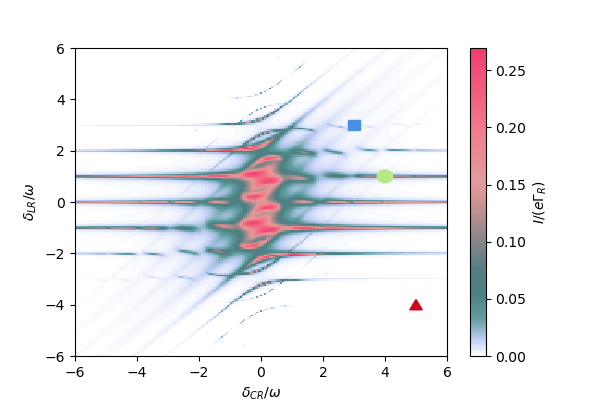

In [13]:
resultados_mat = np.array(resultados.real).reshape((len(deltaRC), len(deltaLR)))

fig, ax = plt.subplots(figsize=(6,4))
im = ax.imshow((resultados_mat), cmap = custom_cmap, origin='lower', aspect='auto',
                interpolation='none', extent=[min(deltaRC), max(deltaRC), min(deltaLR), max(deltaLR)], vmin = 0, vmax = max(resultados).real)
plt.ylabel(r'$\delta_{LR}/\omega$')
plt.xlabel(r'$\delta_{CR}/\omega$')
cbar = plt.colorbar(im)
cbar.ax.set_ylabel(r'$I/(e\Gamma_R)$')

from matplotlib.patches import PathPatch
from matplotlib.path import Path
from matplotlib.patches import Circle

#simbolos

codes1 = [Path.MOVETO] + [Path.LINETO]*3 + [Path.CLOSEPOLY]
vertices1 = [(2.8, 2.8), (2.8, 3.2), (3.2, 3.2), (3.2, 2.8), (0, 0)]

codes2 = [Path.MOVETO] + [Path.LINETO]*2 + [Path.CLOSEPOLY]
vertices2 = [(4.8, -4.2), (5, -3.8), (5.2, -4.2), (0, 0)]

path1 = Path(vertices1, codes1)
path2 = Path(vertices2, codes2)

pathpatch1 = PathPatch(path1, facecolor='#4A90E2', edgecolor='#4A90E2')
pathpatch2 = PathPatch(path2, facecolor='#D0021B', edgecolor='#D0021B')
patch3= Circle((4,1), radius=0.25, color='#B8E986')

ax.add_patch(pathpatch1)
ax.add_patch(pathpatch2)
ax.add_patch(patch3)

plt.savefig('current_tqd_driv.pdf')